In [1]:
#Import nessesary libraries

import pandas as pd
import sqlite3
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime
from urllib.error import URLError
import numpy as np
from itertools import permutations
from collections import OrderedDict
from datetime import timedelta

# pip install geopy #This is used to calculate distance based on lat and long... no need to reinvent the wheel...

from geopy.distance import great_circle

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
#Read in top airport data from supplied files
#combine the two data frames into one
path = 'hw_5_data/'
#db_name = 'airports2.db'
db_name = 'airport_db_v4.db'
top_airpots = pd.read_csv(path+'top_airports.csv' )
airport_info = pd.read_csv(path+'ICAO_airports.csv' )

airport_info['ICAO'] = airport_info['ident']
combined_airport_info = top_airpots.merge(airport_info, on='ICAO')

combined_airport_info.head()

,City,FAA,IATA,ICAO,Airport,Role,Enplanements,id,ident,type,...,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,Atlanta,ATL,ATL,KATL,Hartsfield-Jackson Atlanta International Airport,P-L,43130585,3384,KATL,large_airport,...,US,US-GA,Atlanta,yes,KATL,ATL,ATL,http://www.atlanta-airport.com/,http://en.wikipedia.org/wiki/Hartsfield-Jackso...,NaN
1,Chicago,ORD,ORD,KORD,Chicago O'Hare International Airport,P-L,32171831,3754,KORD,large_airport,...,US,US-IL,Chicago,yes,KORD,ORD,ORD,http://www.flychicago.com/Ohare/OhareHomepage....,http://en.wikipedia.org/wiki/O'Hare_Internatio...,"CHI, Orchard Place"
2,Los Angeles,LAX,LAX,KLAX,Los Angeles International Airport,P-L,30528737,3632,KLAX,large_airport,...,US,US-CA,Los Angeles,yes,KLAX,LAX,LAX,http://www.iflylax.com/,http://en.wikipedia.org/wiki/Los_Angeles_Inter...,NaN
3,Dallas-Fort Worth,DFW,DFW,KDFW,Dallas/Fort Worth International Airport,P-L,27100656,3488,KDFW,large_airport,...,US,US-TX,Dallas-Fort Worth,yes,KDFW,DFW,DFW,http://www.dfwairport.com/,http://en.wikipedia.org/wiki/Dallas-Fort_Worth...,QDF
4,Denver,DEN,DEN,KDEN,Denver International Airport,P-L,25241962,3486,KDEN,large_airport,...,US,US-CO,Denver,yes,KDEN,DEN,DEN,http://www.flydenver.com/,http://en.wikipedia.org/wiki/Denver_Internatio...,NaN


## Make SQL tables

In [3]:
connection = sqlite3.connect(path+db_name)
cursor = connection.cursor()

#Create a table for the airport info and a table for the corresponding weather
sql_info_cmd = """CREATE TABLE info (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ICAO TEXT,
    name TEXT,
    city TEXT,
    latitude_deg FLOAT,
    longitude_deg FLOAT,
    elevation FLOAT,
    enplanements INT)"""


sql_weather_cmd = """CREATE TABLE weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ICAO TEXT,
    date DATE,
    temp_high FLOAT,
    temp_ave FLOAT,
    temp_low FLOAT,
    humidity_ave FLOAT,
    precipitation FLOAT)"""

cursor.execute(sql_info_cmd)
cursor.execute(sql_weather_cmd)
connection.commit()

## Helper Functions to deal with formating dates for data frames

In [4]:
# Helper functions to format dates and get date range to request data

def month_to_int(string):
    month_dict ={'Jan' : 1,
                 'Feb' : 2,
                 'Mar' : 3,
                 'Apr' : 4,
                 'May' : 5,
                 'Jun' : 6,
                 'Jul' : 7,
                 'Aug' : 8,
                 'Sep' : 9,
                 'Oct' : 10,
                 'Nov' : 11,
                 'Dec' : 12}
    return month_dict[string]

def month_to_str(int):
    months =['Jan' ,'Feb' ,'Mar' ,'Apr' ,'May' ,'Jun' ,'Jul' ,'Aug' ,'Sep' ,'Oct' ,'Nov' ,'Dec' ]
    return months[int]


def strip_date(date):
    date_temp = date.split('/')
    year = date_temp[0]
    month = date_temp[1]
    day = date_temp[2]
    
    return year,month,day

def inc_by_year(date):
    '''
    Helper function to incriment a given date by one year,
    expects to be in format %Y/%m/%d
    '''
    date_temp = date.split('/')
    year_inc = str(int(date_temp[0])+1)
    new_date = '{}/{}/{}'.format(year_inc, date_temp[1], date_temp[2])
    return new_date

def inc_by_day(date):
    '''
    Helper function to incriment a given date by one day,
    expects to be in format %Y/%m/%d
    '''
    date_temp = date.split('/')
    day_inc = str(int(date_temp[2])+1)
    new_date = '{}/{}/{}'.format(date_temp[0], date_temp[1], day_inc)
    return new_date


def get_date_range_to_query(date_start,date_end):
    '''
    Weatherunderground historical data only returns a years worth of data at a time,
    this function takes the users defined date range, and returns a list of start and end dates divided
    into year long chunks. 
    '''
    if date_end == 'today':
        today = datetime.now()
        date_end = '{}/{}/{}'.format(today.year, today.month, today.day)
    
    date_range = list()
    dates_temp_list = list()
    
    dates_temp_list.append(date_start)
    
    date_delta = (datetime.strptime(date_end, '%Y/%m/%d') - datetime.strptime(date_start, '%Y/%m/%d'))
    date_delta_years = int(date_delta.total_seconds()/(60*60*24*365.2425))
    
    for iyear in range(date_delta_years):
        temp_date = inc_by_year(dates_temp_list[iyear])
        dates_temp_list.append(temp_date)
        
    lgc_first_interation = True    
    
    for idate in range(len(dates_temp_list)):
        if lgc_first_interation:
            try:
                date_range.append([dates_temp_list[idate],dates_temp_list[idate+1]])
            except:
                date_range.append([dates_temp_list[idate],date_end])           
        else:
            try:
                date_range.append([inc_by_day(dates_temp_list[idate]),dates_temp_list[idate+1]])
            except:
                date_range.append([dates_temp_list[idate],date_end])
        lgc_first_interation = False  
    
    return date_range


#get_date_range_to_query(date_start,date_end='today')
    
    
    

# Scrape data from weather underground


In [7]:
def scrape_data(airport_code, date_start,date_end,data_needed,data_list):
    '''
    This function getting the info from WU for a specified start and end date, for a given airport code.
    'data_needed' is an ordered ditcionary that gives tells what columns of data to keep. This function expects 
    a range of dates of a year or less. This requirement will be taken care of by the program that calls it. 
    
    '''
    start_year, start_month, start_day = strip_date(date_start)
    end_year, end_month, end_day = strip_date(date_end)
    
    month_str = month_to_str(int(start_month))
    current_year = int(start_year)
    current_month_temp = int(start_month)
    
    url = url = 'https://www.wunderground.com/history/airport/{}/{}/CustomHistory.html?dayend={}&monthend={}&yearend={}'.format(
            airport_code, date_start, end_day, end_month, end_year)
    
    response = urlopen(url)
    html = response.read()
    response.close()
    
    # Use Beautiful soup 
    soup = BeautifulSoup(html, "html.parser")
    
    # Grab the second table
    table = soup.findAll('table')[1]
    #results = list()

    for iline, line in enumerate(table.findAll('tr')):
        #we need to ignore the header. All the headers have the text 'high' 'low' 'ave' ..etc. so 
        #if we just check that one of these words is not in the line we are looking at. If it is, then we grab
        #the month name from it, then we will skip the header

        values_per_line = list()
        if 'high' in line.text:
            month_temp = line.text[0]
            for ivalue, value in enumerate(line.findAll('td')):
                if ivalue == 0:
                    month_str = ''.join([word.rstrip() for word in value.findAll(text=True)])
                    current_month = month_to_int(month_str)
            
        if 'high' not in line.text:

                
            #itterate through all the values in the line
            for ivalue, value in enumerate(line.findAll('td')):

                
                if ivalue in data_needed.values():
                    
                    stripped_vals = ''.join([word.rstrip() for word in value.findAll(text=True)])
                    
                    values_per_line.append(stripped_vals)
            

        if values_per_line != []: #make sure there is data in the list
            if current_month < int(current_month_temp):
                current_year += 1
                current_month_temp = current_month
            if current_month == start_month:
                if values_per_line[0] < int(start_day):
                    current_year += 1
                    current_month_temp = current_month
            current_day =  int(values_per_line[0])      
            temp_date =  '{}-{}-{}'.format(str(current_year),str(current_month),str(current_day))
            values_per_line[0] = temp_date
            
            #need to check that all the expected dates are there. some files seem to be missing data
            #we do this by checking that the day before is the expected day
            #check if the first of the month, if yes, then that is correct, if not, check that the 
            #day before is one less than that day
            #if we are missing a day, we add the data from the previous day to that slot
            if (current_day != 1) and (data_list != []): 
                previous_date = data_list[-1][0].split('-')
                
                if (int(previous_date[1]) == current_month) and (int(previous_date[2]) < current_day-1):
                    previous_data = data_list[-1]
                    temp_date =  '{}-{}-{}'.format(str(current_year),str(current_month),str(int(previous_date[2])+1))
                    previous_data[0] = temp_date
                    print('Fixing missing data')
                    data_list.append(previous_data)
                if (int(previous_date[1]) < current_month) and (int(previous_date[2]) > current_day-1):
                    previous_data = data_list[-1]
                    temp_date =  '{}-{}-{}'.format(str(current_year),str(current_month),str(int(previous_date[2])+1))
                    previous_data[0] = temp_date
                    print('Fixing missing data')
                    data_list.append(previous_data)
            
            
            
            data_list.append(values_per_line)
    
    return data_list

def get_weather_data(airport_code,date_start='2008/3/11',date_end = 'today'):
    
    data_needed = OrderedDict({'date': 0, 'temp_high': 1, 'temp_ave': 2, 'temp_low': 3,
                                    'humidity_ave': 8, 'precipitation': 19})
    
    date_range = get_date_range_to_query(date_start,date_end)
    data_list = []
    for idate in range(len(date_range)):
        scrape_data(airport_code, date_range[idate][0],date_range[idate][1],data_needed,data_list)
        print('collected data for range {} - {}'.format(date_range[idate][0],date_range[idate][1]))

            
    data_df = pd.DataFrame(data_list, columns=data_needed.keys())
    for key in data_needed.keys():
        if key != 'date':
            data_df[key] = pd.to_numeric(data_df[key], errors='coerce')
    data_df = data_df.fillna(0)
    
    return data_df
    

    

    

   

### Populate airport info table

In [8]:
print('Populating info table...')
for i, line in combined_airport_info.iterrows():
    print('Iteration: ', i)
    data_per_line = (line['ICAO'], line['Airport'], line['City'], line['latitude_deg'], line['longitude_deg'],
                  line['elevation_ft'], line['Enplanements'])
    cursor.execute('INSERT INTO info' + '(ICAO, name, city, latitude_deg, longitude_deg, elevation,\
                    enplanements) ' + 'VALUES (?, ?, ?, ?, ?, ?, ?)', data_per_line)
connection.commit()    

Populating info table...
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49


### Populate airport weather table

In [22]:

#This code can take quite a while to run! Also, the internet connection at my house is less than ideal, so I 
#occasionally needed to restart part way through. 
#if the data scraper gets hung up for too long, interupt, do: 'connection.commit()', and restart this cell
#starting with the iteration that it stoped at

print('Populating weather table...')
for i, line in combined_airport_info[49:].iterrows(): 


    print('Iteration: ', i, ' Airport: ', line['ICAO'])
    
    #A classmate recommended that I use a check to catch when WU tries to disconect you,
    #but this did not seem to come up for me. 
    lgc_connection = False
    while lgc_connection == False: 
        try:
            weather_data = get_weather_data(airport_code = line['ICAO'])
            print('Data Processed')
            lgc_connection = True
        except URLError:
            print('Connection to WeatherUnderground broken')
            pass
    for irow, weatherRow in weather_data.iterrows():
        data =  (line['ICAO'], weatherRow['date'], weatherRow['temp_high'], 
                weatherRow['temp_ave'], weatherRow['temp_low'], weatherRow['humidity_ave'], weatherRow['precipitation'])
        cursor.execute('INSERT INTO weather' + '(ICAO, date, temp_high, temp_ave, temp_low, humidity_ave, precipitation) ' + \
                        'VALUES (?, ?, ?, ?, ?, ? , ?)', data)
connection.commit()  
connection.close()
print('Table complete')

Populating weather table...
Iteration:  49  Airport:  KIND
collected data for range 2008/3/11 - 2009/3/11
collected data for range 2009/3/12 - 2010/3/11
collected data for range 2010/3/12 - 2011/3/11
collected data for range 2011/3/12 - 2012/3/11
collected data for range 2012/3/12 - 2013/3/11
collected data for range 2013/3/12 - 2014/3/11
collected data for range 2014/3/12 - 2015/3/11
collected data for range 2015/3/12 - 2016/3/11
collected data for range 2016/3/12 - 2017/3/11
Fixing missing data
collected data for range 2017/3/12 - 2018/3/11
collected data for range 2018/3/11 - 2018/3/12
Data Processed
Table complete


In [21]:
connection.commit()  
#connection.close()

# Analysis Section

In [23]:
#Helper function to get data from a given database

def get_data_from_db(db_name, path, sql_cmd):
        connection = sqlite3.connect(path+db_name)
        cursor = connection.cursor()
        connection.row_factory = lambda cursor, row: row[0] #so that we don't get a list back everytime we use.fetchall()
        c = connection.cursor()
        data = c.execute(sql_cmd).fetchall()
        connection.close()
        return data
    

### Analysis computation code

In [27]:


#Create dictionary to hold all the correlation data
airport_pairs_dict = {}
column_names = ['Airport_pairs','highT_1','highT_3','highT_7',\
                'precip_1','precip_3','precip_7','dist','long_delta' ]
for key in column_names: 
    airport_pairs_dict[key] = list()
    
    

###Get airport codes from database
sql_cmd = "SELECT ICAO FROM info"
airport_code = get_data_from_db(db_name,path, sql_cmd)
#airport_code = list(set(get_data_from_db(db_name,path, sql_cmd)))
#print(len(airport_code))

'''
##### temporary code to eliminate bad files in database ###
bad_airport = np.array(['KIAH','KLGA','KMSY','KIND'])
airport_code = np.asarray(airport_code)
cuts = np.ones(shape=airport_code.shape, dtype=bool)
bad_indx = np.where(airport_code == 'KIAH')#np.array([word for word in bad_airport]))
cuts[bad_indx] = 0
bad_indx = np.where(airport_code == 'KLGA')#[word for word in bad_airport])
cuts[bad_indx] = 0
bad_indx = np.where(airport_code == 'KMSY')#[word for word in bad_airport])
cuts[bad_indx] = 0
bad_indx = np.where(airport_code == 'KIND')#[word for word in bad_airport])
cuts[bad_indx] = 0
'''

### calculate the correlations for all permutations of airports
for combo in permutations(airport_code,2):
    
    #print(combo)
    
    sql_cmd_highT_1 = "SELECT temp_high FROM weather where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_highT_2 = "SELECT temp_high FROM weather where ICAO = " + '"' + str(combo[1] + '"')
    
    sql_cmd_precip_1 = "SELECT precipitation FROM weather where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_precip_2 = "SELECT precipitation FROM weather where ICAO = " + '"' + str(combo[1] + '"')
    
    sql_cmd_lat_1 = "SELECT latitude_deg FROM info where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_lat_2 = "SELECT latitude_deg FROM info where ICAO = " + '"' + str(combo[1] + '"')
    
    sql_cmd_long_1 = "SELECT longitude_deg FROM info where ICAO = " + '"' + str(combo[0] + '"')
    sql_cmd_long_2 = "SELECT longitude_deg FROM info where ICAO = " + '"' + str(combo[1] + '"')
    

    high_temp_1 = get_data_from_db(db_name,path,sql_cmd_highT_1)
    high_temp_2 = get_data_from_db(db_name,path,sql_cmd_highT_2)
    
    precip_1 = get_data_from_db(db_name,path,sql_cmd_precip_1)
    precip_2 = get_data_from_db(db_name,path,sql_cmd_precip_2)
    
    lat_1 = get_data_from_db(db_name,path,sql_cmd_lat_1)[0]
    lat_2 = get_data_from_db(db_name,path,sql_cmd_lat_2)[0]
    
    long_1 = get_data_from_db(db_name,path,sql_cmd_long_1)[0]
    long_2 = get_data_from_db(db_name,path,sql_cmd_long_2)[0]
    
    #when calculating correlations, shift one array by 1,3,and 7 days to get
    #the 1,3, and 7 day correlations
    
    ##string='[{} , {}]'.format(len(high_temp_1),len(high_temp_2)) #for debuging
    ##print(string)
    
    n = 3652 #for some reason a few of the arrays are missing a few elements
    #I know this is not the best fix, but it is taking too long to re populate the db to 
    #try to fix it properly
    one_highT_coeff   = np.corrcoef(high_temp_1[:n-1],high_temp_2[1:n])[0,1]
    three_highT_coeff = np.corrcoef(high_temp_1[:n-3],high_temp_2[3:n])[0,1]
    seven_highT_coeff = np.corrcoef(high_temp_1[:n-7],high_temp_2[7:n])[0,1]
    
    one_precip_coeff   = np.corrcoef(precip_1[:n-1],precip_2[1:n])[0,1]
    three_precip_coeff = np.corrcoef(precip_1[:n-3],precip_2[3:n])[0,1]
    seven_precip_coeff = np.corrcoef(precip_1[:n-7],precip_2[7:n])[0,1]
    
    long_delta = long_2-long_1 #difference in longitude
    
    distance = great_circle((lat_1,long_1),(lat_2,long_2)).miles #absolute distance between cities
    
    #append each value to our dictionary
    airport_pairs_dict['Airport_pairs'].append(combo)
    airport_pairs_dict['highT_1'].append(one_highT_coeff)
    airport_pairs_dict['highT_3'].append(three_highT_coeff)
    airport_pairs_dict['highT_7'].append(seven_highT_coeff)
    airport_pairs_dict['precip_1'].append(one_precip_coeff)
    airport_pairs_dict['precip_3'].append(three_precip_coeff)
    airport_pairs_dict['precip_7'].append(seven_precip_coeff)
    airport_pairs_dict['dist'].append(distance)
    airport_pairs_dict['long_delta'].append(long_delta)
    

#turn data dictonary into pandas df, setting the city pair as the index
pairs_df = pd.DataFrame.from_dict(airport_pairs_dict).set_index('Airport_pairs') 

    
    


### Plotting

In [33]:
import seaborn as sns
sns.set_style('darkgrid')


### Not sure of the best way to present the data. Unfortunately I spent way too much time of the web scraper to 
# put more time into plotting the results in a more meaningful way. It would be interesting to see which airport-pairs
# correspond to which data points, but I feel that this would make the plotts too messy. 

def plot_results(df,x_val,y_val,title):
    #x_val = ['long_delta','dist']
    #y_val = ['highT_1','highT_3','highT_7']#,'precip_1','precip_3','precip_7']
    
    
    fig, ax = plt.subplots(1, len(x_val), figsize = (6 * len(x_val), 3 * len(x_val)))
    fig.canvas.set_window_title(title)
    
    for ii in range(len(x_val)):
        for jj in range(len(y_val)):
            
            ax[ii].set_xlabel(x_val[ii])
            ax[ii].set_ylabel('Correlation coefficient')
            
            
            df_sort = df.sort_values(by = y_val[jj], ascending=False)[:10]
            
            ax[ii].plot(df_sort[x_val[ii]], df_sort[y_val[jj]], 'o', label = y_val[jj])
            ax[ii].legend(loc = 'best')
            
    plt.tight_layout()
    
    
    
    
    
    
x_val = ['long_delta','dist']
y_val_temp = ['highT_1','highT_3','highT_7']
y_val_precip = ['precip_1','precip_3','precip_7']    
    
    
    




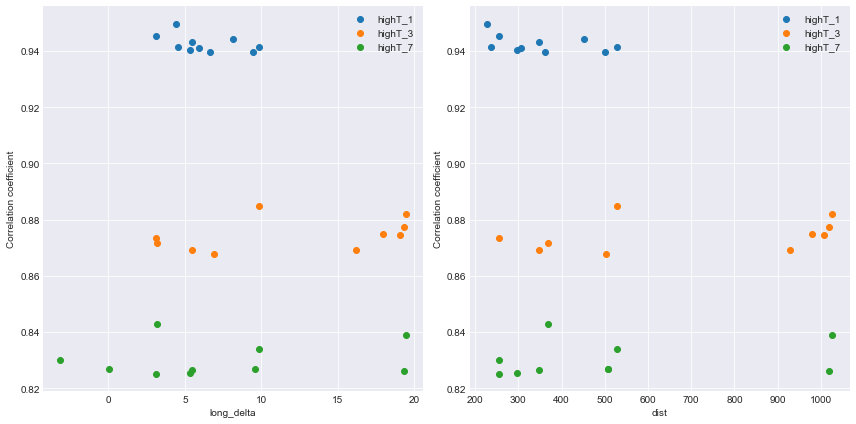

In [34]:
plot_results(pairs_df,x_val,y_val_temp, 'Top 10 Temperature correlation')

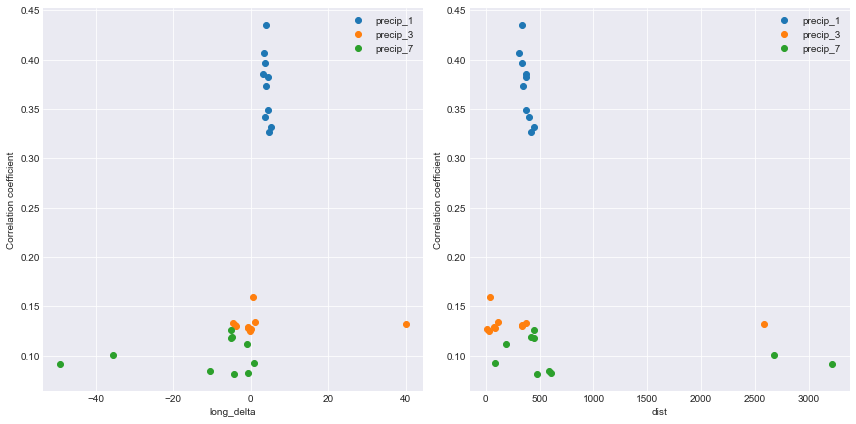

In [35]:
plot_results(pairs_df,x_val,y_val_precip,'Top 10 Precipitation correlations')